In [ ]:
##BERT

In [40]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch
import pandas as pd
import os

# Load model and tokenizer
mmodel_path = r"D:\Final Thesis Data\results\BERT_Saved"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)
model.to("cpu").eval()


CLASS_NAMES = {
    0: "False/Misleading", 
    1: "True/Accurate"
}

def predict_socio_economic(statement, evidence):
    text = f"Socio-economic claim: {statement} Context: {evidence}"
    inputs = tokenizer(
        text,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1).numpy()[0]
    
    pred_class = probs.argmax()
    confidence = probs.max() * 100

    return {
        "prediction": CLASS_NAMES[pred_class],
        "confidence": f"{confidence:.1f}%",
        "all_probabilities": {CLASS_NAMES[i]: f"{p*100:.1f}%" for i, p in enumerate(probs)}
    }

# Change directory and load test data
os.chdir(r'D:\Final Thesis Data\results\BERT_Saved')
print("Current working directory:", os.getcwd())

df = pd.read_csv("test_no_empty_evidence.csv")

# Predict for first 10 rows
for i, row in df.head(30).iterrows():
    statement = str(row["statement"])
    evidence = str(row["evidence"])
    actual = "True/Accurate" if row["label"] == 1 else "False/Misleading"
    
    pred = predict_socio_economic(statement, evidence)
    
    print("\n---")
    print(f"Statement: {statement}")
    print(f"Evidence: {evidence}")
    print(f"Actual Label: {actual}")
    print(f"Predicted Label: {pred['prediction']} ({pred['confidence']})")
    print("Probabilities:")
    for cls, prob in pred['all_probabilities'].items():
        print(f"  {cls}: {prob}")


Current working directory: D:\Final Thesis Data\results\BERT_Saved

---
Statement: Building a wall on the U.S.-Mexico border will take literally years.
Evidence: "Building a wall" on the border "will take literally years. I don’t care how good of a builder you are," Perry said about 40 minutes into an interview on the Jan. 15, 2016, edition of the Simon Conway Show on WHO in Des Moines. "And plus the private property rights," Perry said. "This is an issue that really gets complex in a hurry. I know because I’ve had to deal with it." If Trump has a fast-track plan to plan the wall, purchase required land, complete needed studies and erect the wall in a year or less, it’s not public. Meantime, engineering experts agree the wall would most likely take years to complete. Keep in mind, too, it took more than six years to build roughly 700 miles of fence and barriers along the roughly 2,000-mile U.S.-Mexico border. Perry’s assertion got us thinking, what would go into building a wall from so

In [ ]:
##DistilledBert

In [42]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

distilledbert_path = r"D:\Final Thesis Data\results\DistilledBert"

# Load tokenizer and model from your local directory
tokenizer_distilled = AutoTokenizer.from_pretrained(distilledbert_path)
model_distilled = AutoModelForSequenceClassification.from_pretrained(distilledbert_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_distilled.to(device)
model_distilled.eval()

def predict_distilledbert(statement, evidence):
    # Prepare input: often concatenated with [SEP] token for paired inputs
    inputs = tokenizer_distilled(
        statement,
        evidence,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt",
    )
    
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model_distilled(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]

    # Assuming labels: 0=False/Misleading, 1=True/Accurate
    label_map = {0: "False/Misleading", 1: "True/Accurate"}

    pred_idx = probs.argmax()
    prediction = label_map[pred_idx]
    confidence = round(float(probs[pred_idx]) * 100, 1)

    all_probabilities = {
        label_map[i]: round(float(prob) * 100, 1) for i, prob in enumerate(probs)
    }

    return {
        "prediction": prediction,
        "confidence": confidence,
        "all_probabilities": all_probabilities,
    }

# Change directory and load test data
os.chdir(r'D:\Final Thesis Data\results\BERT_Saved')
print("Current working directory:", os.getcwd())

df = pd.read_csv("test_no_empty_evidence.csv")
for i, row in df.head(20).iterrows():
    statement = str(row["statement"])
    evidence = str(row["evidence"])
    actual = "True/Accurate" if row["label"] == 1 else "False/Misleading"
    
    pred = predict_distilledbert(statement, evidence)
    
    print("\n---")
    print(f"Statement: {statement}")
    print(f"Evidence: {evidence}")
    print(f"Actual Label: {actual}")
    print(f"Predicted Label: {pred['prediction']} ({pred['confidence']}%)")
    print("Probabilities:")
    for cls, prob in pred['all_probabilities'].items():
        print(f"  {cls}: {prob}%")



---
Statement: Building a wall on the U.S.-Mexico border will take literally years.
Evidence: "Building a wall" on the border "will take literally years. I don’t care how good of a builder you are," Perry said about 40 minutes into an interview on the Jan. 15, 2016, edition of the Simon Conway Show on WHO in Des Moines. "And plus the private property rights," Perry said. "This is an issue that really gets complex in a hurry. I know because I’ve had to deal with it." If Trump has a fast-track plan to plan the wall, purchase required land, complete needed studies and erect the wall in a year or less, it’s not public. Meantime, engineering experts agree the wall would most likely take years to complete. Keep in mind, too, it took more than six years to build roughly 700 miles of fence and barriers along the roughly 2,000-mile U.S.-Mexico border. Perry’s assertion got us thinking, what would go into building a wall from southernmost California to the southern tip of Texas? And would Trump

In [ ]:
##gpt2

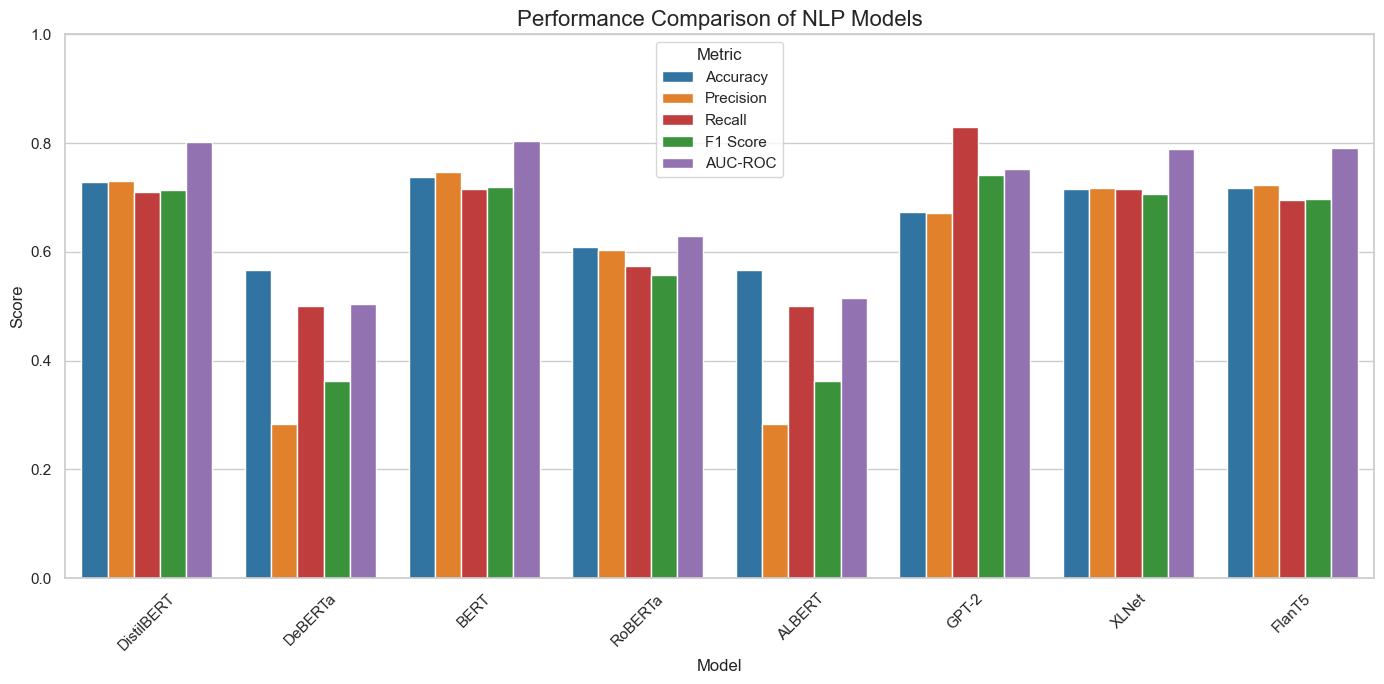

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data
data = {
    'Model': ['DistilBERT', 'DeBERTa', 'BERT', 'RoBERTa', 'ALBERT', 'GPT-2', 'XLNet', 'FlanT5'],
    'Accuracy': [0.7278, 0.5672, 0.7373, 0.6091, 0.5672, 0.6732, 0.7152, 0.71677],
    'Precision': [0.72969, 0.28362, 0.74683, 0.60365, 0.28362, 0.6715, 0.7182, 0.7228],
    'Recall': [0.7102, 0.5, 0.716, 0.5733, 0.5, 0.8298, 0.7152, 0.695],
    'F1 Score': [0.7131, 0.3619, 0.7191, 0.5569, 0.3619, 0.7423, 0.7064, 0.69711],
    'AUC-ROC': [0.8021, 0.5051, 0.8043, 0.6288, 0.5145, 0.7525, 0.7896, 0.79031]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Melt for seaborn
df_melted = df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")
palette = {
    'Accuracy': '#1f77b4',
    'Precision': '#ff7f0e',
    'Recall': '#d62728',
    'F1 Score': '#2ca02c',
    'AUC-ROC': '#9467bd'
}
sns.barplot(x='Model', y='Score', hue='Metric', data=df_melted, palette=palette)

# Aesthetics
plt.title('Performance Comparison of NLP Models', fontsize=16)
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.tight_layout()

# Show plot
plt.show()


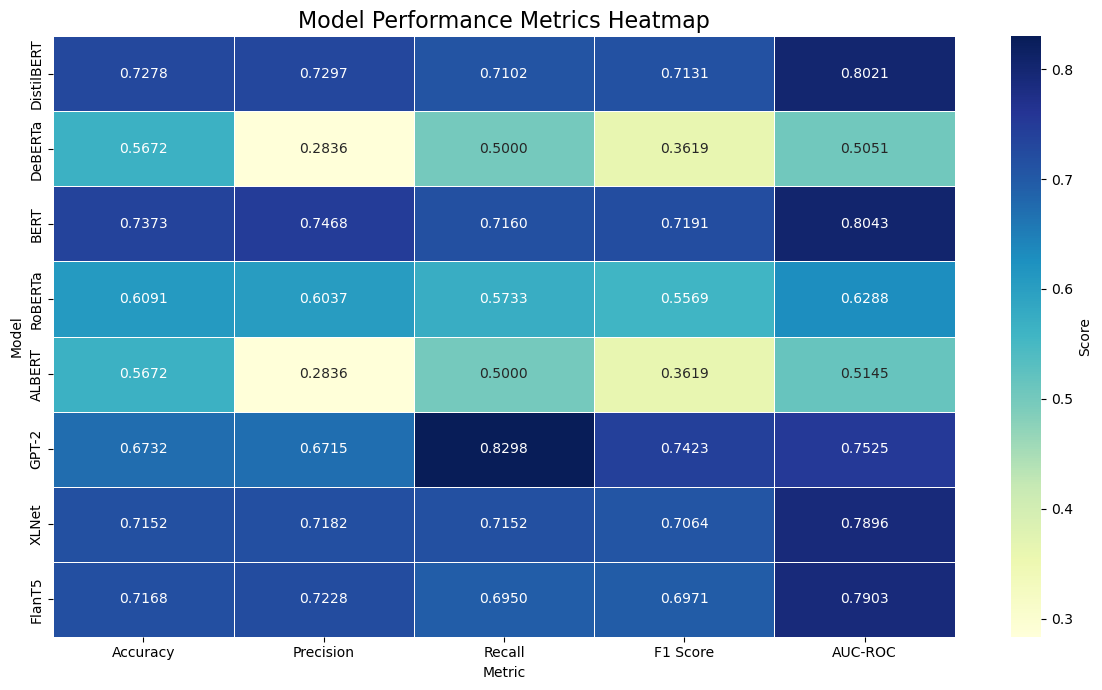

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data
data = {
    'Model': ['DistilBERT', 'DeBERTa', 'BERT', 'RoBERTa', 'ALBERT', 'GPT-2', 'XLNet', 'FlanT5'],
    'Accuracy': [0.7278, 0.5672, 0.7373, 0.6091, 0.5672, 0.6732, 0.7152, 0.71677],
    'Precision': [0.72969, 0.28362, 0.74683, 0.60365, 0.28362, 0.6715, 0.7182, 0.7228],
    'Recall': [0.7102, 0.5, 0.716, 0.5733, 0.5, 0.8298, 0.7152, 0.695],
    'F1 Score': [0.7131, 0.3619, 0.7191, 0.5569, 0.3619, 0.7423, 0.7064, 0.69711],
    'AUC-ROC': [0.8021, 0.5051, 0.8043, 0.6288, 0.5145, 0.7525, 0.7896, 0.79031]
}

# Create DataFrame
df = pd.DataFrame(data)
df.set_index('Model', inplace=True)

# Plot heatmap
plt.figure(figsize=(12, 7))  # Larger figure for better quality
sns.heatmap(df, annot=True, fmt=".4f", cmap="YlGnBu", linewidths=0.5, cbar_kws={'label': 'Score'})

# Aesthetics
plt.title("Model Performance Metrics Heatmap", fontsize=16)
plt.ylabel("Model")
plt.xlabel("Metric")
plt.tight_layout()

# Save high-res image
plt.savefig("model_performance_heatmap.png", dpi=300, bbox_inches='tight')  # ← Save before show

# Show plot
plt.show()

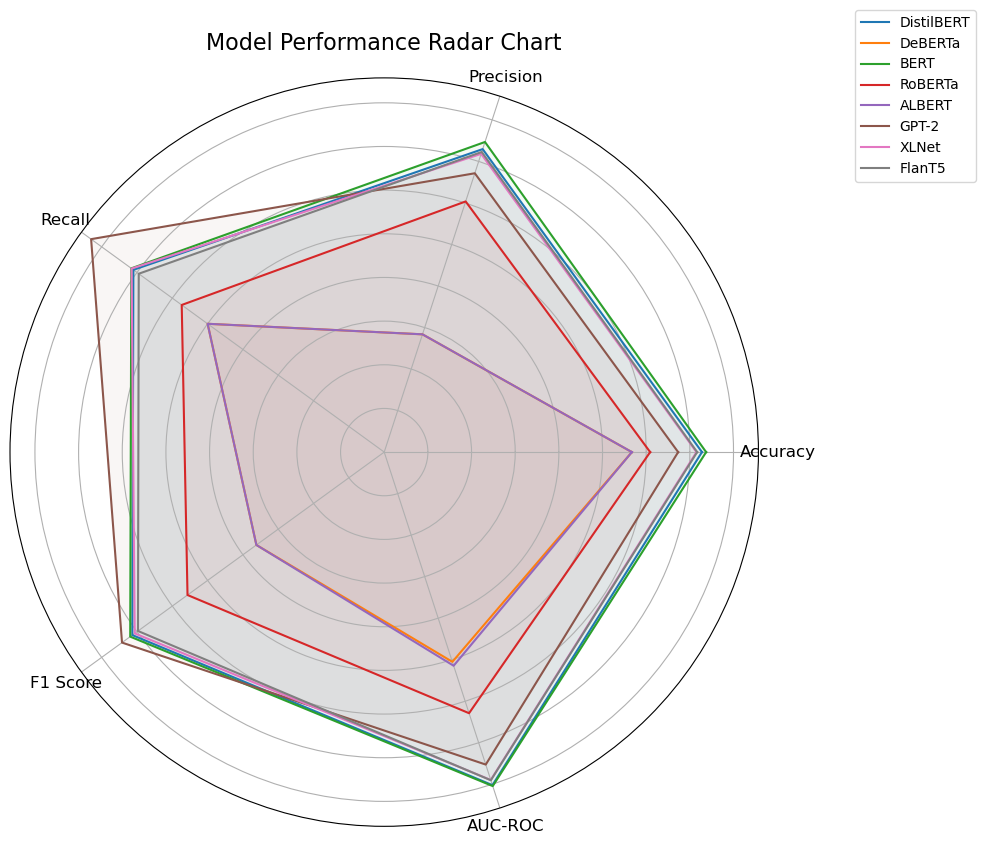

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data
data = {
    'Model': ['DistilBERT', 'DeBERTa', 'BERT', 'RoBERTa', 'ALBERT', 'GPT-2', 'XLNet', 'FlanT5'],
    'Accuracy': [0.7278, 0.5672, 0.7373, 0.6091, 0.5672, 0.6732, 0.7152, 0.71677],
    'Precision': [0.72969, 0.28362, 0.74683, 0.60365, 0.28362, 0.6715, 0.7182, 0.7228],
    'Recall': [0.7102, 0.5, 0.716, 0.5733, 0.5, 0.8298, 0.7152, 0.695],
    'F1 Score': [0.7131, 0.3619, 0.7191, 0.5569, 0.3619, 0.7423, 0.7064, 0.69711],
    'AUC-ROC': [0.8021, 0.5051, 0.8043, 0.6288, 0.5145, 0.7525, 0.7896, 0.79031]
}

df = pd.DataFrame(data)

# Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']
num_vars = len(metrics)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Radar chart setup
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Plot each model
for i, row in df.iterrows():
    values = row[metrics].tolist()
    values += values[:1]
    ax.plot(angles, values, label=row['Model'])
    ax.fill(angles, values, alpha=0.05)

# Axis setup
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=12)
ax.set_yticklabels([])
ax.set_title("Model Performance Radar Chart", size=16, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()

# Save high-resolution image
plt.savefig("model_performance_radar_chart.png", dpi=300, bbox_inches='tight')  # Save before showing

# Display plot
plt.show()

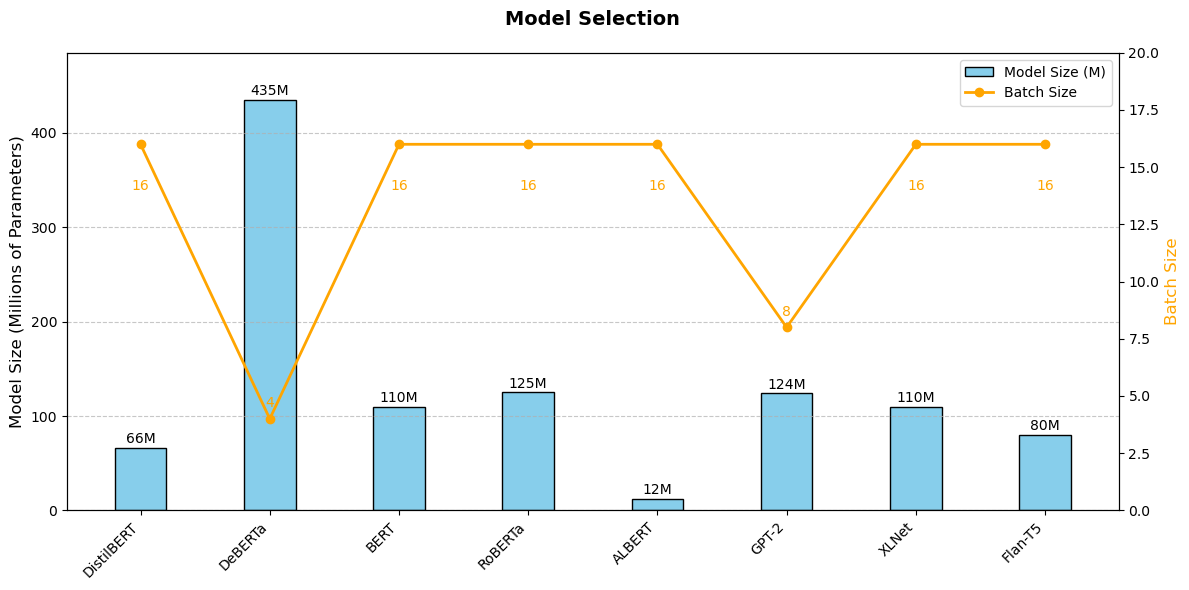

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = [
    "DistilBERT", "DeBERTa", "BERT", "RoBERTa",
    "ALBERT", "GPT-2", "XLNet", "Flan-T5"
]
sizes = [66, 435, 110, 125, 12, 124, 110, 80]
batches = [16, 4, 16, 16, 16, 8, 16, 16]

x = np.arange(len(models))
width = 0.4

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar for model sizes
bars = ax1.bar(x, sizes, width, label='Model Size (M)', color='skyblue', edgecolor='black')

# Annotate size values
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval + 5, f'{yval}M', ha='center', fontsize=10)

# Add batch size as a line on the same x-axis
ax2 = ax1.twinx()
ax2.plot(x, batches, color='orange', marker='o', label='Batch Size', linewidth=2)

# Annotate batch size values slightly below top
for i, b in enumerate(batches):
    ax2.text(x[i], b + 0.5 if b < 15 else b - 2, f'{b}', ha='center', color='orange', fontsize=10)

# Aesthetics
ax1.set_ylabel('Model Size (Millions of Parameters)', fontsize=12)
ax2.set_ylabel('Batch Size', fontsize=12, color='orange')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.set_title('Model Selection', fontsize=14, weight='bold', pad=20)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust Y-limits to avoid overlap
ax1.set_ylim(0, max(sizes) + 50)
ax2.set_ylim(0, 20)

# Legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.savefig("model_comparison_chart.png", dpi=300)
plt.show()

C:\Users\quesi\AppData\Local\Temp\ipykernel_12824\3681116973.py:56: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



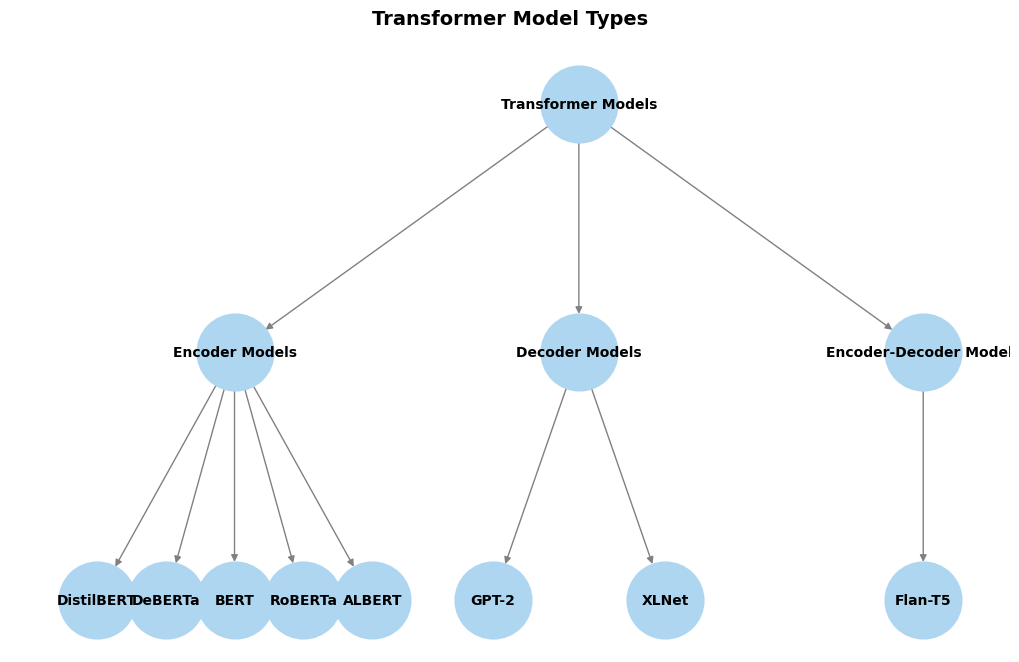

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Root
G.add_node("Transformer Models")

# First level
G.add_node("Encoder Models")
G.add_node("Decoder Models")
G.add_node("Encoder-Decoder Models")
G.add_edges_from([
    ("Transformer Models", "Encoder Models"),
    ("Transformer Models", "Decoder Models"),
    ("Transformer Models", "Encoder-Decoder Models")
])

# Encoder models
encoder_models = ["DistilBERT", "DeBERTa", "BERT", "RoBERTa", "ALBERT"]
for model in encoder_models:
    G.add_edge("Encoder Models", model)

# Decoder models
decoder_models = ["GPT-2", "XLNet"]
for model in decoder_models:
    G.add_edge("Decoder Models", model)

# Encoder-Decoder models
G.add_edge("Encoder-Decoder Models", "Flan-T5")

# Position the nodes using hierarchy layout
def hierarchy_pos(G, root, width=1., vert_gap=0.3, vert_loc=0, xcenter=0.5):
    pos = {}
    def _hierarchy_pos(G, root, left, right, vert_loc, xcenter, pos, parent=None):
        pos[root] = (xcenter, vert_loc)
        children = list(G.successors(root))
        if not children:
            return pos
        dx = (right - left) / len(children)
        nextx = left
        for child in children:
            nextx_center = nextx + dx / 2
            pos = _hierarchy_pos(G, child, nextx, nextx + dx, vert_loc - vert_gap, nextx_center, pos, root)
            nextx += dx
        return pos
    return _hierarchy_pos(G, root, 0, width, vert_loc, xcenter, pos)

pos = hierarchy_pos(G, "Transformer Models")

# Plotting
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color="#AED6F1", node_size=3000, font_size=10, font_weight='bold', edge_color='gray', linewidths=1.5)
plt.title("Transformer Model Types", fontsize=14, weight='bold', pad=20)
plt.tight_layout()
plt.savefig("transformer_model_tree.png", dpi=300)
plt.show()
